In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

Using TensorFlow backend.


In [3]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [5]:
# train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11493376/11490434 [==============================] - 102s 9us/step


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
 - 12s - loss: 190.3045 - val_loss: 172.8799
Epoch 2/50
 - 10s - loss: 169.8792 - val_loss: 168.5599
Epoch 3/50
 - 10s - loss: 166.8850 - val_loss: 165.6600
Epoch 4/50
 - 10s - loss: 164.7693 - val_loss: 164.2146
Epoch 5/50
 - 10s - loss: 163.1971 - val_loss: 162.5936
Epoch 6/50
 - 10s - loss: 161.9778 - val_loss: 161.5990
Epoch 7/50
 - 9s - loss: 160.9487 - val_loss: 160.7404
Epoch 8/50
 - 10s - loss: 159.9801 - val_loss: 159.8603
Epoch 9/50
 - 11s - loss: 159.0667 - val_loss: 159.1659
Epoch 10/50
 - 11s - loss: 158.2783 - val_loss: 158.2080
Epoch 11/50
 - 10s - loss: 157.5079 - val_loss: 157.9335
Epoch 12/50
 - 11s - loss: 156.7781 - val_loss: 157.4951
Epoch 13/50
 - 10s - loss: 156.2077 - val_loss: 156.8051
Epoch 14/50
 - 11s - loss: 155.6865 - val_loss: 156.2540
Epoch 15/50
 - 11s - loss: 155.2488 - val_loss: 155.5379
Epoch 16/50
 - 11s - loss: 154.8245 - val_loss: 155.1124
Epoch 17/50
 - 11s - loss: 154.4213 - val_loss: 

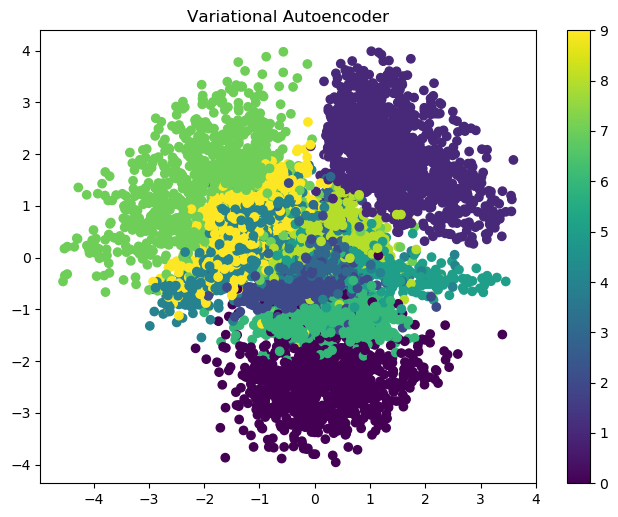

In [6]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        validation_data=(x_test, None))

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.title('Variational Autoencoder')
plt.colorbar()
plt.show()

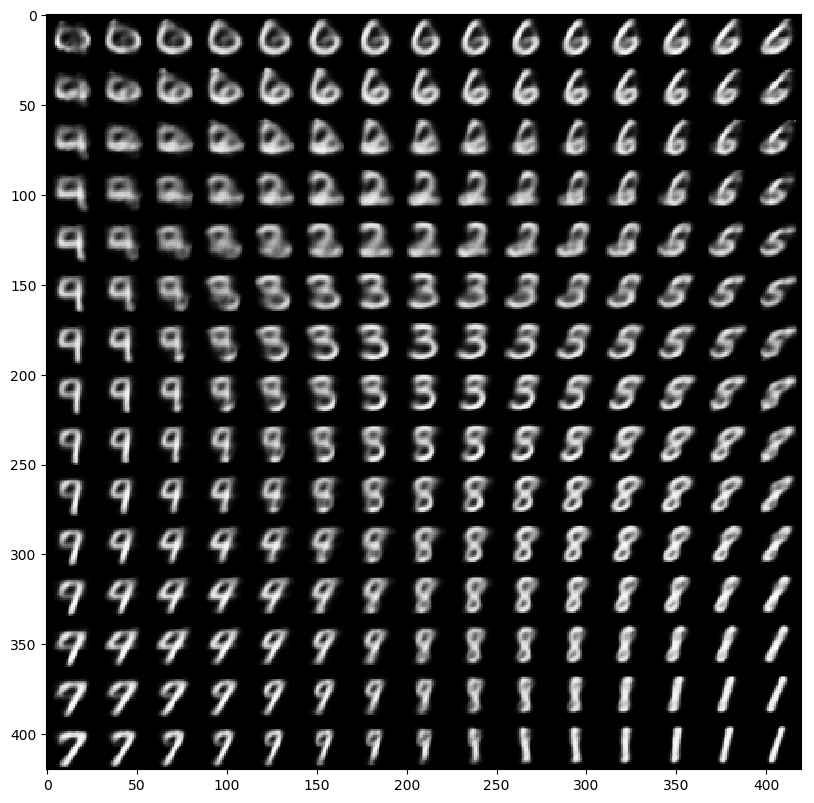

In [7]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(figure, cmap='Greys_r')
plt.show()